In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

from utils import *
from debugger import *

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Latex-like font for plots
# Note: if LaTeX is not installed, do not run this cell
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "cmr10",
    "text.latex.preamble": r"\usepackage{amsmath, amssymb}",
    "font.size": 16})

In [3]:
# Controls
twoN = 4
g_values = np.linspace(0, 3, 10)
max_iterations = 100000
tau = 1.0e-5

# Real-space RG algorithm

In [4]:
# Save energies and iterations
final_energies_rsrg = []
iters_rsrg = []

message_checkpoints(0, "Start looping over g values...", debug=True)
for g in g_values:

    currentN = twoN
    epsilon_rsrg = 0.0
    energy_densities = []
    
    # Initialize hamiltonian for this g
    H_L, H_R, A, B, H = RSRG_init(twoN, g=g)

    tot_iterations = max_iterations # if do not converges

    # RG Loop
    converged = False
    for i in range(max_iterations):
        
        # RG Step
        E0, H_L, H_R, A, B, H = RSRG_update(H_L, H_R, A, B, H)
        
        # Update Energy Density
        epsilon_rsrg += E0 / currentN
        energy_densities.append(epsilon_rsrg)
        
        # Check Convergence
        if len(energy_densities) > 1:
            diff = np.abs(energy_densities[-1] - energy_densities[-2])
            if diff < tau:
                converged = True
                tot_iterations = i+1
                break

        # Double system size
        currentN *= 2
        
    # Store final result
    final_energies_rsrg.append(energy_densities[-1])
    iters_rsrg.append(tot_iterations)
    
    # Print loop status
    message_checkpoints(0, f"g: {g:.2f}, iter: {i+1}, system size: {currentN}, energy density: {energy_densities[-1]:.3f}, converged in {i+1} iterations.", debug=True)

message_checkpoints(0, "Loop done!", debug=True)


Start looping over g values...
g: 0.00, iter: 16, system size: 131072, energy density: -1.004, converged in 16 iterations.
g: 0.33, iter: 16, system size: 131072, energy density: -1.014, converged in 16 iterations.
g: 0.67, iter: 15, system size: 65536, energy density: -1.074, converged in 15 iterations.
g: 1.00, iter: 14, system size: 32768, energy density: -1.224, converged in 14 iterations.
g: 1.33, iter: 16, system size: 131072, energy density: -1.482, converged in 16 iterations.
g: 1.67, iter: 16, system size: 131072, energy density: -1.783, converged in 16 iterations.
g: 2.00, iter: 18, system size: 524288, energy density: -2.096, converged in 18 iterations.
g: 2.33, iter: 18, system size: 524288, energy density: -2.415, converged in 18 iterations.
g: 2.67, iter: 18, system size: 524288, energy density: -2.738, converged in 18 iterations.
g: 3.00, iter: 18, system size: 524288, energy density: -3.063, converged in 18 iterations.
Loop done!


# iDMRG algorithm

In [5]:
# Controls
m_max = 4
m_limit = 20         
max_steps = 20000

In [6]:
# Save energies and iterations
final_energies_dmrg = []
iters_dmrg = []

# iDMRG loop
message_checkpoints(0, "Start looping over g values...", debug=True)
for g in g_values:

    # Initialization 
    Hm, A = iDMRG_init(g=g)
    
    # Trackers for this g
    block_size = 1
    energies = []
    
    converged = False
    tot_iterations = max_steps # if do not converges

    # Loop
    for i in range(max_steps):
        
        # Update Step: Grow block by 1 site
        Hm, A, E_total = iDMRG_update(Hm, A, g=g, m=m_limit)
        block_size += 1
        superblock_size = 2 * block_size
        
        # Compute energy density
        epsilon_dmrg = E_total/superblock_size
        energies.append(epsilon_dmrg)
        
        # Check Convergence
        if len(energies) > 1:
            diff = np.abs(energies[-1] - energies[-2])
            if diff < tau:
                converged = True
                tot_iterations = i+1
                break
    
    final_energies_dmrg.append(energies[-1])
    iters_dmrg.append(tot_iterations)
    
    # Print loop status
    message_checkpoints(0, f"g: {g:.2f}, iter: {i+1}, system size: {superblock_size}, energy density: {energies[-1]:.3f}, converged in {i+1} iterations.", debug=True)

message_checkpoints(0, "Loop done!", debug=True)

Start looping over g values...
g: 0.00, iter: 224, system size: 450, energy density: -0.998, converged in 224 iterations.
g: 0.33, iter: 217, system size: 436, energy density: -1.026, converged in 217 iterations.
g: 0.67, iter: 195, system size: 392, energy density: -1.113, converged in 195 iterations.
g: 1.00, iter: 135, system size: 272, energy density: -1.272, converged in 135 iterations.
g: 1.33, iter: 103, system size: 208, energy density: -1.528, converged in 103 iterations.
g: 1.67, iter: 90, system size: 182, energy density: -1.820, converged in 90 iterations.
g: 2.00, iter: 81, system size: 164, energy density: -2.126, converged in 81 iterations.
g: 2.33, iter: 75, system size: 152, energy density: -2.441, converged in 75 iterations.
g: 2.67, iter: 69, system size: 140, energy density: -2.761, converged in 69 iterations.
g: 3.00, iter: 65, system size: 132, energy density: -3.083, converged in 65 iterations.
Loop done!


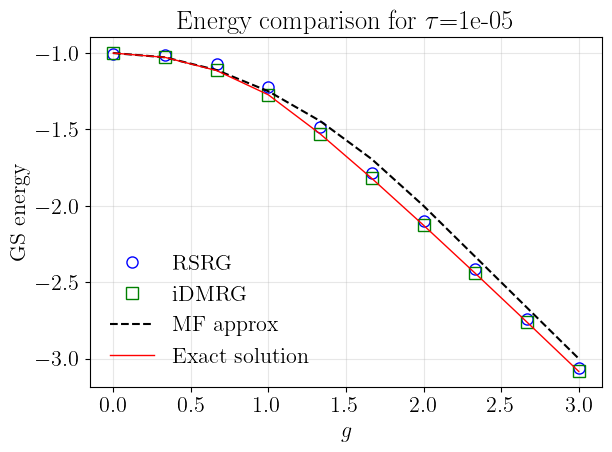

In [7]:
fig, ax = plt.subplots()

# Compute the exact curve
def exact_ising_energy(g):
    def integrand(k):
        return np.sqrt(1 + g**2 + 2*g*np.cos(k))
    result, _ = quad(integrand, 0, np.pi)
    return -1.0/np.pi * result

exact_curve = [exact_ising_energy(g) for g in g_values]

# Plot RSRG and iDMRG data
ax.plot(g_values, final_energies_rsrg, "o", linewidth=2, markersize=8, markerfacecolor="none", color="blue", label="RSRG")
ax.plot(g_values, final_energies_dmrg, "s", linewidth=2, markersize=8, markerfacecolor="none", color="green", label="iDMRG")

# Define Mean Field function
def MF(g):
    if np.abs(g) < 2:
        return -1 - g**2/4
    else:
        return -np.abs(g)

# Create theoretical curve
mf_curve = [MF(g) for g in g_values]

# Plot MF and Theoretical curves
ax.plot(g_values, mf_curve, linestyle="dashed", color="black", label="MF approx")
ax.plot(g_values, exact_curve, color="red", linestyle="solid", linewidth=1, label="Exact solution")

ax.set_title(rf"Energy comparison for $\tau$={tau}")
ax.set_xlabel(r"$g$")
ax.set_ylabel(r"GS energy")
ax.legend(frameon=False)
ax.grid(True, which="both", alpha=0.3)

plt.tight_layout()
plt.savefig("energy_comparison.pdf", dpi=300)
plt.show()

### Algorithm precision

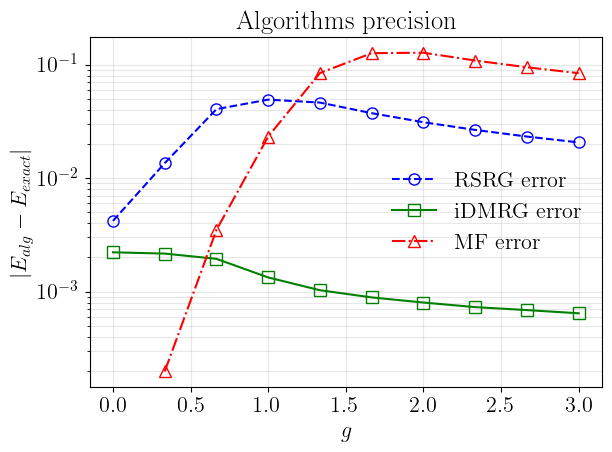

In [8]:
# Perform a plot of the absolute errors with the exact solution
fig, ax = plt.subplots()

# Compute absolute errors
error_RSRG = np.abs(np.array(final_energies_rsrg) - np.array(exact_curve))+1e-16
error_iDMRG = np.abs(np.array(final_energies_dmrg) - np.array(exact_curve))+1e-16
error_MF = np.abs(np.array(mf_curve) - np.array(exact_curve))+1e-16

ax.plot(g_values, error_RSRG, "o--", markersize=8, color="blue", markerfacecolor="none", label="RSRG error")
ax.plot(g_values, error_iDMRG, "s-", markersize=8, color="green", markerfacecolor="none", label="iDMRG error")
ax.plot(g_values[1:], error_MF[1:], "^-.", markersize=8, color="red", markerfacecolor="none", label="MF error")

ax.set_yscale("log")
ax.set_xlabel(r"$g$")
ax.set_ylabel(r"$|E_{alg} - E_{exact}|$")
ax.set_title("Algorithms precision")
ax.legend(frameon=False)
ax.grid(True, which="both", alpha=0.3)

plt.tight_layout()
plt.savefig("algos_precision.pdf", dpi=300)
plt.show()

### Convergence speed benchmark

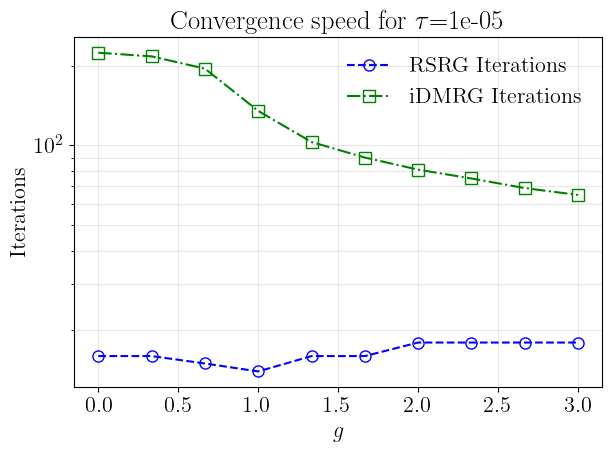

In [9]:
# Convergence speed (number of iterations to converge) plot
fig, ax = plt.subplots()

ax.plot(g_values, iters_rsrg, "o--", markersize=8, label="RSRG Iterations", color="blue", markerfacecolor="none")
ax.plot(g_values, iters_dmrg, "s-.", markersize=8, label='iDMRG Iterations', color="green", markerfacecolor="none")

ax.set_yscale("log")
ax.set_ylabel(r"Iterations")
ax.set_xlabel(r"$g$")
ax.set_title(rf"Convergence speed for $\tau$={tau}")
ax.legend(frameon=False)
ax.grid(True, which="both", alpha=0.3)

plt.tight_layout()
plt.savefig("convergence_speed.pdf", dpi=300)
plt.show()